# BioSound Tutorial

**!WORK IN PROGRESS!: currently working on porting over the tutorials at https://github.com/theunissenlab/BioSoundTutorial so they can be run in a colab notebook**


In this tutorial, we will

* Download a small dataset of 25 distance calls produced by 4 zebra finches from our public github repository [here](https://github.com/theunissenlab/BioSoundTutorial)

* Use **BioSound** to extract sound features from these data files and save them in .h5 files

* Export sound features from each file to 

* Fit supervised classifiers to the dataset (LDA, QDA, RandomForest)


## 0. Setup

The first cell will detect if the notebook is running in a Google colab environment and download the BioSoundTutorial data from GitHub.

**Run this cell only once!**

In [6]:
%%capture
import sys
import os

try:
  import google.colab
  IS_COLAB = True
except:
  IS_COLAB = False

if IS_COLAB:
  %cd /content

  if "soundsig" not in sys.modules:
    %pip install soundsig

  if not os.path.exists("BioSoundTutorial"):
    !git clone https://github.com/theunissenlab/BioSoundTutorial

  %cd /content/BioSoundTutorial

## 1. Reading a WAV file

A WAV file can be read using the `soundsig.sound.WavFile` object, then used to initialize a `soundsig.sound.BioSound` object.

The methods `spectroCalc`, `ampenv`, `spectrum`, `fundest`, and `mpsCalc` compute features of the sound and cache them in several attributes of the BioSound object.

The method `plot()` generates a variable number of graphs depending on what quantities have been calculated.

In [23]:
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

from soundsig.sound import BioSound 
from soundsig.sound import WavFile

In [26]:
#@title Defining output files
INPUT_FOLDER = "BirdCalls"  #@param {type: "string"}
H5_FOLDER = "h5files"  #@param {type: "string"}

input_files = glob.glob(os.path.join(INPUT_FOLDER, "*.wav"))
print("Found {} files".format(len(input_files)))

if not os.path.exists(H5_FOLDER):
    os.makedirs(H5_FOLDER)

Found 91 files


In [27]:
#@title Select the file to process
FILENAME = "WhiLbl0010_110411-DC-01.wav"  #@param {type: "string"}


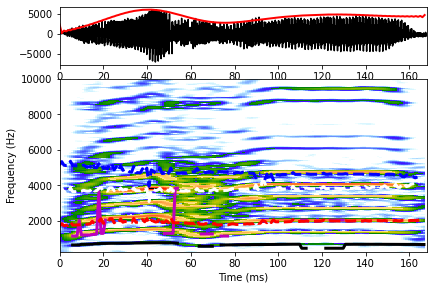

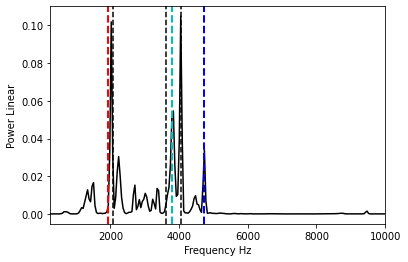

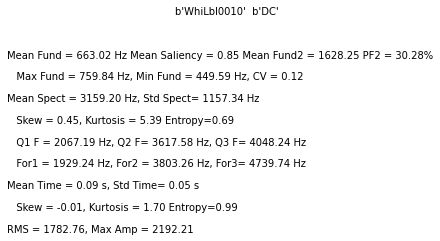

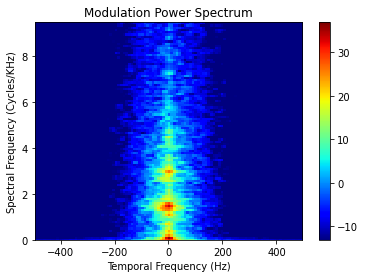

In [12]:
# Read the sound file
soundIn = WavFile(file_name=os.path.join(INPUT_FOLDER, FILENAME)) 
filename, _ = os.path.splitext(FILENAME)

# Here we parse the filename to get the birdname and the call type. 
# You will have to write custom code to extract your own identifiers.
birdname = filename[0:10]
calltype = filename[18:20]

# Create BioSound Object
myBioSound = BioSound(
    soundWave=soundIn.data.astype(float),
    fs=float(soundIn.sample_rate),
    emitter=birdname,
    calltype = calltype
  )
      
# Calculate the spectrogram and the rms
myBioSound.spectroCalc(
    spec_sample_rate=1000,
    freq_spacing=50,
    min_freq=0,
    max_freq=10000
)
myBioSound.rms = myBioSound.sound.std() 

# Calculate amplitude enveloppe
myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)

# Calculate the power spectrum
myBioSound.spectrum(f_high=10000)

# Calculate fundamental and related values.  These are the default values.
#   For the estimation of the fundamental, four methods are available: 
#   'AC' - Peak of the auto-correlation function
#   'ACA' - Peak of envelope of auto-correlation function 
#   'Cep' - First peak in cepstrum 
#   'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)
myBioSound.fundest(
    maxFund = 1500,
    minFund = 300,
    lowFc = 200,
    highFc = 6000, 
    minSaliency = 0.5,
    debugFig = 0, 
    minFormantFreq = 500,
    maxFormantBW = 500,
    windowFormant = 0.1,
    method="Stack"
  )

# Calculate the MPS
myBioSound.mpsCalc(window=0.1, Norm = True)

# Plot the result
myBioSound.plot(DBNOISE=50, f_low=250, f_high=10000)  


1. The first figure shows the oscillogram and spectrogram of the sound. The red bold line on the oscillogram is the **amplitude envelope**. The black bold line on the spectrogram is the **estimated fundamental frequency**. The purple bold line on the spectrogram is the estimated fundamental frequency of a second voice (when it exists). The red, white and blue bold lines on the specrogram are the estimated **first, second and third formants (F1, F2, F3)**.

3. The second figure is a **power spectrum**. The black dotted lines show the quartiles. The red, light blue and dark blue dotted lines are the **time average values of F1, F2, F3**.

3. The third figure shows the values of other BioSound parameters.

4. The fourth figure shows the **modulation power spectrum**.

The calculations last approximately 1 minute for a 1 second sound on 2.7 GHz Intel Core i7. The slowest routine is the fundamental estimator.


## 2. Process all WAV files and save to .h5 files

We now want to save the features we have calculated into .h5 files so we don't need to recompute them every time. We can do this with the `BioSound.saveh5()` method.

**! This step will take some time (~13min) to complete - we could provide precomputed files on github as an option to skip this step**

In [ ]:
# Find all the wave files 
for fname in tqdm.notebook.tqdm(glob.glob(os.path.join(INPUT_FOLDER, "*.wav"))):
    # Read the sound file
    soundIn = WavFile(file_name=fname) 
    filename, _ = os.path.splitext(fname)

    # Here we parse the filename to get the birdname and the call type. 
    # You will have to write custom code to extract your own identifiers.
    basename = os.path.basename(filename)
    birdname = filename[0:10]
    calltype = filename[18:20]
    
    # Create BioSound Object
    myBioSound = BioSound(
        soundWave=soundIn.data.astype(float),
        fs=float(soundIn.sample_rate),
        emitter=birdname,
        calltype = calltype
      )
          
    # Calculate the spectrogram and the rms
    myBioSound.spectroCalc(
        spec_sample_rate=1000,
        freq_spacing=50,
        min_freq=0,
        max_freq=10000
    )
    myBioSound.rms = myBioSound.sound.std() 
    
    # Calculate amplitude enveloppe
    myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
    
    # Calculate the power spectrum
    myBioSound.spectrum(f_high=10000)

    # Calculate fundamental and related values.  These are the default values.
    #   For the estimation of the fundamental, four methods are available: 
    #   'AC' - Peak of the auto-correlation function
    #   'ACA' - Peak of envelope of auto-correlation function 
    #   'Cep' - First peak in cepstrum 
    #   'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)
    myBioSound.fundest(
        maxFund = 1500,
        minFund = 300,
        lowFc = 200,
        highFc = 6000, 
        minSaliency = 0.5,
        debugFig = 0, 
        minFormantFreq = 500,
        maxFormantBW = 500,
        windowFormant = 0.1,
        method="Stack"
      )
  
    # Calculate the MPS
    myBioSound.mpsCalc(window=0.1, Norm = True)
            
    # Save the results
    fh5name = os.path.join(H5_FOLDER, "{}.h5".format(basename))
    myBioSound.saveh5(fh5name)

## 3. Re-loading a BioSound .h5 file

The .h5 files that you have just created can then be reloaded using `BioSound.readh5(path)`.

In [20]:
LOAD_FILENAME = "/content/BioSoundTutorial/h5files/WhiLbl0010_110421-DC-11.h5"  #@param

In [21]:
    myBioSound = BioSound()
    myBioSound.readh5(LOAD_FILENAME)

## 4. Store table of features in a dataframe

We next want to create a pandas `DataFrame` table where **each row represents one sound file** (one call in our dataset) and **each column is one sound feature** we will use for classification.

To do this, we will load the `BioSound` objects from our .h5 files generated in Step 2, convert them into dictionary rows of a `DataFrame`, and save the resulting table into a new .h5 file.

Note that we are taking the average of F1, F2, and F3. This is because these are time-varying estimates in the BioSound object (with one value per time point), and we want to collapse them into a single avearge.